## Introduction to the Interstellar Medium
### Jonathan Williams

### Figure 11.4: zoom in on CO and Halpha images of a spiral arm in M51

#### HST Halpha data from https://archive.stsci.edu/prepds/m51/
#### IRAM CO 2-1 data from https://www2.mpia-hd.mpg.de/PAWS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import PercentileInterval
from astropy.visualization import ImageNormalize
from astropy.visualization import LinearStretch, SqrtStretch, LogStretch, AsinhStretch
%matplotlib inline

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


    Header size is not multiple of 2880: 1
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
invalid keyvalue. [astropy.wcs.wcs]


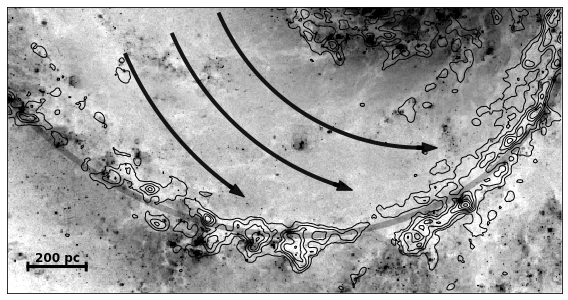

In [2]:
# center chosen based on playing around with ds9
# 13:29:55.059 +47:10:56.470
# convert to decimal using astropy
# from astropy import units as u
# from astropy.coordinates import SkyCoord
# c = SkyCoord('13:29:55.059','+47:10:56.470', unit=(u.hourangle, u.deg))
xcen, ycen = 202.4794125, 47.18435278
xbox, ybox = 0.04, 0.014
world = np.array([[xcen+xbox/2, ycen-ybox/2], [xcen-xbox/2, ycen+ybox/2]])

fitsfile1 = 'NGC5194_Halpha.fits'
hdu1 = fits.open(fitsfile1, ignore_missing_end=True)
wcs1 = WCS(hdu1[0].header)
wcs1.sip = None
im1 = hdu1[0].data
hdu1.close()
pix = np.rint(wcs1.wcs_world2pix(world, 1)).astype(int)
position = (0.5*(pix[0,0]+pix[1,0]), 0.5*(pix[0,1]+pix[1,1]))
size = (pix[1,1]-pix[0,1], pix[1,0]-pix[0,0])
crop1 = Cutout2D(im1, position=position, size=size, wcs=wcs1, mode='partial')
norm1 = ImageNormalize(crop1.data, stretch=AsinhStretch(), interval=PercentileInterval(99))

fitsfile2 = 'NGC5194_IRAM_CO21_mom0.fits'
hdu2 = fits.open(fitsfile2, ignore_missing_end=True)
wcs2 = WCS(hdu2[0].header)
im2 = hdu2[0].data
hdu2.close()
pix = np.rint(wcs2.wcs_world2pix(world, 1)).astype(int)
position = (0.5*(pix[0,0]+pix[1,0]), 0.5*(pix[0,1]+pix[1,1]))
size = (pix[1,1]-pix[0,1], pix[1,0]-pix[0,0])
crop2 = Cutout2D(im2, position=position, size=size, wcs=wcs2, mode='partial')
norm2 = ImageNormalize(crop2.data, stretch=LinearStretch(), interval=PercentileInterval(99))
levs2 = [50, 100, 150, 200, 250, 300, 350, 400]

fig = plt.figure(figsize=(8,4.4))
ax1 = fig.add_subplot(111, projection=crop1.wcs)

ax1.imshow(crop1.data, cmap='gray_r', origin='lower', norm=norm1)
ax1.contour(crop2.data, levels=levs2, colors='black', linewidths=1, transform=ax1.get_transform(crop2.wcs))

# plot a log spiral and rotation
# this is purely an eyeball fit for illustrative purposes only
pix0 = np.array([[300,-100]])
theta = np.linspace(1.08*np.pi,1.71*np.pi,100)
r0 = 35
# two-armed logarithmic spiral
# x ~ sin(theta) for trailing (cos for leading)
b = 0.37
r = r0*np.exp(b*theta)
_x = pix0[0,0] + r*np.sin(theta)
_y = pix0[0,1] + r*np.cos(theta)
# rotate
phi = np.pi/3
x = _x*np.cos(phi) - _y*np.sin(phi)
y = _x*np.sin(phi) + _y*np.cos(phi)
ax1.plot(x,y, 'k-', lw=6, alpha=0.3, transform=ax1.get_transform(crop2.wcs))

# draw arrows for rotation
# galaxy center 13 29 52.698 +47 11 42.93
x0, y0 = 202.469575, 47.19525833
pix0 = crop2.wcs.wcs_world2pix(np.array([[x0,y0]]),1)
r0 = [130, 160, 190]
theta0 = [1.5, 1.4, 1.3]
for i in range(len(r0)):
    theta = np.linspace(1.13*np.pi,theta0[i]*np.pi,50)
    x = pix0[0,0] + r0[i]*np.cos(theta)
    y = pix0[0,1] + r0[i]*np.sin(theta)
    dx = x[-1] - x[-2]
    dy = y[-1] - y[-2]
    ax1.plot(x,y, 'k-', lw=4, alpha=0.9, transform=ax1.get_transform(crop2.wcs))
    ax1.arrow(x[-2],y[-2], dx, dy, width=2, color='black', alpha=0.9, transform=ax1.get_transform(crop2.wcs))

# add a scale bar
# 1 kpc at 8 Mpc = 0.0072 deg = 0.0105*cos(dec) along RA axis
x0, y0 = 202.498, 47.1786
xbar = 0.0105/5
pix = crop2.wcs.wcs_world2pix(np.array([[x0,y0],[x0-xbar,y0+0.1*xbar],[x0-2*xbar,y0]]),1)
dy = 2
ax1.plot([pix[0,0],pix[2,0]], [pix[0,1],pix[0,1]], 'k-', lw=3, transform=ax1.get_transform(crop2.wcs))
ax1.plot([pix[0,0],pix[0,0]], [pix[0,1]-dy,pix[0,1]+dy], 'k-', lw=3, transform=ax1.get_transform(crop2.wcs))
ax1.plot([pix[2,0],pix[2,0]], [pix[0,1]-dy,pix[0,1]+dy], 'k-', lw=3, transform=ax1.get_transform(crop2.wcs))
ax1.text(pix[1,0], pix[1,1], '200 pc', color='black', fontsize=12, fontweight='bold', ha='center', transform=ax1.get_transform(crop2.wcs))

for i in (0,1):
    ax1.coords[i].set_ticks_visible(False)
    ax1.coords[i].set_ticklabel_visible(False)
    ax1.coords[i].set_ticks_visible(False)
    ax1.coords[i].set_ticklabel_visible(False)
    ax1.coords[i].set_axislabel('')
    ax1.coords[i].set_axislabel('')

plt.tight_layout()
plt.savefig('M51_spiral_arms.pdf')